In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict


In [2]:
# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
# Load dataset
train_data = load_dataset('csv', data_files='3_split_data/train.csv')
test_data = load_dataset('csv', data_files='3_split_data/test.csv')
validation_data = load_dataset('csv', data_files='3_split_data/validation.csv')
dataset = DatasetDict({
    'train': train_data['train'],
    'test': test_data['train'],
    'validation': validation_data['train']
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['content', 'label'],
        num_rows: 9856
    })
    test: Dataset({
        features: ['content', 'label'],
        num_rows: 2113
    })
    validation: Dataset({
        features: ['content', 'label'],
        num_rows: 2112
    })
})


In [5]:
# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
def tokenize_function(examples):
    contents = [str(content) for content in examples['content']]
    return tokenizer(contents, padding="max_length", truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9856
    })
    test: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2113
    })
    validation: Dataset({
        features: ['content', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2112
    })
})


In [6]:
print("Train example:")
print("Content:", tokenized_dataset['train'][0]['content'])
print("Label:", tokenized_dataset['train'][0]['label'])
print("Input IDs:", tokenized_dataset['train'][0]['input_ids'])
print("Attention Mask:", tokenized_dataset['train'][0]['attention_mask'])

Train example:
Content: भुवन पौडेल काठमाडौं चैत धितोपत्रको बजारमा सानो रकम संकलन लागत महँगिएपछि विकल्प खोज्नुपर्ने देखिएको धितोपत्रको प्राथमिक बजारमार्फत सानो पुँजी संकलन संस्थाले निष्कासन रकमहाराहारीमै खर्च गर्नुपरेपछि विकल्प खोज्नुपर्ने देखिएको पुँजी संकलनका गरिने सेयर निष्कासनको लागत बढेसँगै सम्बन्धित कम्पनीका प्रावधान निल्नु ओकल्नु’ केहीअघि सर्वसाधारणमा सेयर निष्कासन जनउत्थान लघुवित्त विकास बैंकको रुपैयाँबराबरको कित्तामध्ये सामूहिक लगानी कोषलाई छुट्ट्याएपछिको रुपैयाँबराबरको कित्ता सेयरका गुणा आवेदन परेको निष्कासनका कुल रुपैयाँ खर्च सेयर निष्कासन बिक्री प्रबन्धकबीचको सम्झौता खर्च बेहोर्ने सन्दर्भमा बैंक बिक्री प्रबन्धकबीच विवाद आएपछि धितोपत्र बोर्डको मध्यस्थतामा समस्या समाधान बजारको कारोबार खुलेको हालैमात्र साधारण सेयर निष्कासन माइक्रोफाइनान्समा गुणा आवेदन परेको संस्थाले निष्कासन कित्ता सेयरका परेको अधिक आवेदनले खर्च निश्चित माइक्रोफाइनान्सको साधारण सेयर निष्कासनमा परेको अधिक आवेदनअनुसार करिब करोड खर्च लाग्ने धितोपत्रको प्राथमिक बजारबाट सानो रकम संकलन खर्चिनुपरेका उदाहरणमात्र यसअघि 

In [7]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=12)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.optim import AdamW

# Define compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training Parameters
batch_size = 10
no_epochs = 4
train_len = len(dataset['train'])
steps = (train_len * no_epochs) / batch_size

# Training Arguments with Optimizations
training_args = TrainingArguments(
    eval_strategy="epoch",
    logging_strategy="steps",
    save_strategy="epoch",
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=train_len // batch_size,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=no_epochs,
    weight_decay=0.05,
    learning_rate=5e-5,
    warmup_steps=int(0.05 * steps),
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
    bf16=True,  # Use fp16 for faster training
    # gradient_accumulation_steps=2,  # Reduce memory load and still achieve a larger effective batch size
    gradient_checkpointing=True  # Reduce memory usage
)


# Trainer initialization with AdamW and custom callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    optimizers=(AdamW(model.parameters(), lr=training_args.learning_rate), None),  # Faster AdamW optimizer
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # Early stopping for fewer epochs if no improvement
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.197600,0.873882,0.717803,0.660982,0.717803,0.681440
2,0.735700,0.617570,0.806818,0.781887,0.806818,0.788627
3,0.549100,0.550884,0.827178,0.826336,0.827178,0.819415
4,0.433100,0.522212,0.835701,0.831762,0.835701,0.831431


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=3944, training_loss=0.728512426902508, metrics={'train_runtime': 8552.3864, 'train_samples_per_second': 4.61, 'train_steps_per_second': 0.461, 'total_flos': 1.037382158647296e+16, 'train_loss': 0.728512426902508, 'epoch': 4.0})

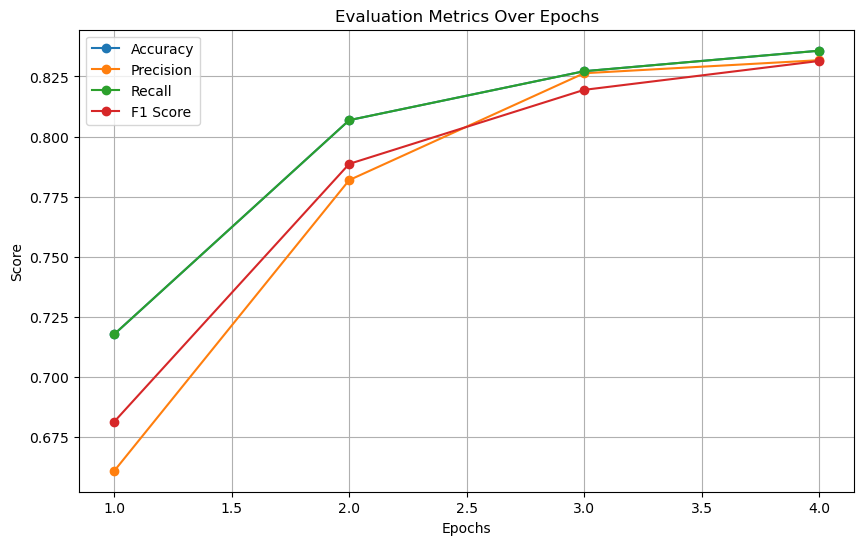

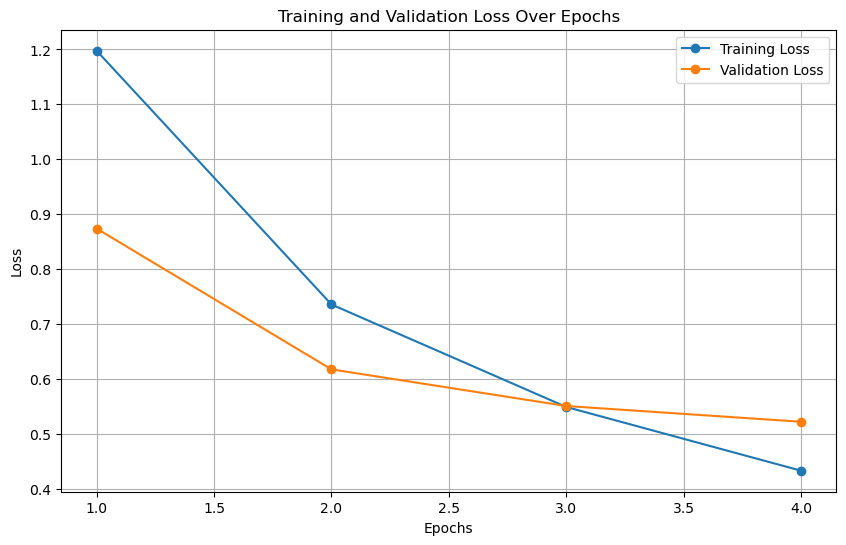

In [9]:
# Retrieve training history
training_history = trainer.state.log_history

# Extract evaluation metrics and losses after each epoch
epochs = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
training_losses = []
eval_losses = []

for log in training_history:
    if 'eval_accuracy' in log:  # Log evaluation metrics
        epochs.append(log['epoch'])
        accuracies.append(log['eval_accuracy'])
        precisions.append(log['eval_precision'])
        recalls.append(log['eval_recall'])
        f1_scores.append(log['eval_f1'])
    if 'loss' in log:  # Log training loss
        training_losses.append(log['loss'])
    if 'eval_loss' in log:  # Log evaluation loss
        eval_losses.append(log['eval_loss'])

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.plot(epochs, precisions, label='Precision', marker='o')
plt.plot(epochs, recalls, label='Recall', marker='o')
plt.plot(epochs, f1_scores, label='F1 Score', marker='o')

plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Save the model
trainer.save_model('./nepali_news_xmlrobert_fine_tuned_model')